# Fake News Detection Using Natural Language Processing (NLP) and Classification Modeling

## Team members: Antonia & Pravat

## Abstract
How might Natural Language Processing better inform us about how fake news filters get created? 

This assigment attempts to distinguish between _fake news_ and _absurd news_ by building a classification model. We believe it's imperative to maintain a high level of accuracy when creating a fake news detector--where all fake news gets filtered out and authentic news will not be affected by a filter.

## 1. Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import re

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
from wordcloud import WordCloud
import cufflinks as cf
import itertools

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Natural language processing
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from nltk.corpus import stopwords
from textblob import Word

# Tagging
import en_core_web_sm

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

# Warning and Disable
import warnings

warnings.filterwarnings("ignore")

In [2]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 2. Data Structure

The given **Train** dataset has following fields.

1. **ID**: Unique identification of each news 
2. **title**: Title of the news
3. **text**: Text content of the news
4. **label**: The target variable i.e. whether the news is **FAKE** or **REAL**
5. **X1**: Additional content of the news
6. **X2**: Additional content of the news

The given **Test** dataset all the above fields except **label**, **X1** and **X2**.

## 3. Data Loading

_Note: Please place the TRAIN and TEST data in the same folder, where this python notebook is placed_

In [3]:
# Import TRAIN data
train = pd.read_csv("fake_or_real_news_training.csv")

# Import TEST data
test = pd.read_csv("fake_or_real_news_test.csv")

## 4. Exploratory Data Analysis (EDA)

### 4.1 TRAIN Data Preview

In [4]:
print("Train data shape:", train.shape)
train.head()

Train data shape: (3999, 6)


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


### 4.2 TEST Data Preview

In [5]:
print("Test data shape:", test.shape)
test.head()

Test data shape: (2321, 3)


,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


### 4.3 Is TRAIN Dataset Imbalanced?

Fake News Count: 1976
Real News Count: 1990


Text(0.5, 1.0, 'FAKE Vs REAL')

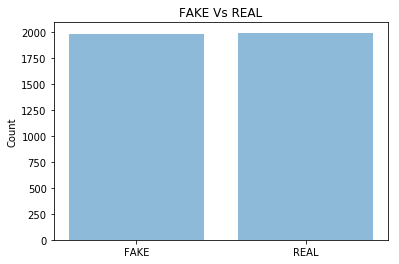

In [6]:
# Check for Class Imbalance
print("Fake News Count:", train[train["label"] == "FAKE"].label.count())
print("Real News Count:", train[train["label"] == "REAL"].label.count())

labels = ("FAKE", "REAL")
y_pos = np.arange(len(labels))
plt.bar(
    y_pos,
    [
        train[train["label"] == "FAKE"].label.count(),
        train[train["label"] == "REAL"].label.count(),
    ],
    align="center",
    alpha=0.5,
)
plt.xticks(y_pos, labels)
plt.ylabel("Count")
plt.title("FAKE Vs REAL")

**So, we conclude that the TRAIN data is quite balanced.**

### 4.4 Summary of TRAIN dataset

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
ID       3999 non-null int64
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: int64(1), object(5)
memory usage: 187.5+ KB


### 4.5 Analyze X1 field

We can see here that X1 and X2 fields have some values and rest of the values are empty. Let's analyze what sort of values these two fields X1 and X2 contain?



In [8]:
train.X1.unique()

array([nan, 'REAL', 'FAKE',
       'PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE.\xa0Congress may have spent August away from Washington but Planned Parenthood’s campaign to convince lawmakers to protect the group’s funding followed them back to their home states. Power Post has more.\n\n“Lawmakers will raise the stakes when Congress returns next week by threatening to defund the group through the federal appropriations process. Planned Parenthood’s counter-offensive is widespread and varied and is unfolding inside and outside the Beltway. The group has been\xa0organizing rallies, flooding lawmakers’ town hall meetings, commissioning polls, shelling\xa0out six figures for television\xa0ads and\xa0hiring forensics experts to try to discredit undercover video footage that sparked the controversy. The success of these lobbying efforts will be tested when Congress returns and must move a short-term spending bill to keep the government open. Some conservatives in both chambers are pushing 

**We can see here that this field contain values such as 'REAL', 'FAKE' and some texts. It seems that the data is quite dirty as it contains some label data and some text data. Let's analyze the same for the field X2.**

### 4.6 Analyze X2 field

In [9]:
train.X2.unique()

array([nan, 'REAL', 'FAKE'], dtype=object)

**It seems that X2 data contains some label data. Let's analyze the same for the field Label.**

### 4.7 Analyze Label field

In [10]:
# train.label.unique()
train.label.unique()[3]

"Who rode it best? Jesse Jackson mounts up to fight pipeline; Leonardo DiCaprio to the rescue? Posted at 6:41 pm on October 26, 2016 by Brett T. Share on Facebook Share on Twitter \nVladimir Putin might have popularized the shirtless-on-horseback calendar pose that was echoed recently by Alex Jones , but Jesse Jackson deserves credit for at least one thing: he chose to keep his shirt on Wednesday when he rode up to the front lines of a protest against the Dakota Access Pipeline. \n— Marisa Villarreal (@marisa_villarr) October 26, 2016 Proud to stand with the Sioux Indians today in North Dakota. #StandingWithStandingRock pic.twitter.com/0dPbDk6RJD \n— Rev Jesse Jackson Sr (@RevJJackson) October 26, 2016 Jesse Jackson on the frontline with that native bling #NoDAPL pic.twitter.com/QevCYFugN3 \n— Ruth Hopkins (@RuthHHopkins) October 26, 2016 \nSeen standing with Jackson (literally; check over his shoulder above) was “Avengers” actor Mark Ruffalo, who offered his own exclusive scoop of sor

**We can see here that 'label' field conatins some values, which look like the text of the news. That means, we are missing here 'label' for several news in the training dataset.**

In [11]:
print(
    "Number of news with missing label: ",
    train.shape[0] - ((train.label == "REAL") | (train.label == "FAKE")).sum(),
)

Number of news with missing label:  33


**So, where can we find the correct labels for these 33 news? Is it present in X1 and/or X2?**

In [12]:
print(
    "Number of news with missing label (considering label, X1 and X2): ",
    train.shape[0]
    - (
        (train.label == "REAL")
        | (train.label == "FAKE")
        | (train.X1 == "REAL")
        | (train.X1 == "FAKE")
        | (train.X2 == "REAL")
        | (train.X2 == "FAKE")
    ).sum(),
)

Number of news with missing label (considering label, X1 and X2):  0


**This means that the missing labels are present in X1 and X2.**

### 4.8 Analyze Text field

In [13]:
print("Number of missing values in text field: ", train.text.isna().sum())

Number of missing values in text field:  0


### 4.9 Analyze Title field

In [14]:
print("Number of missing values in title field: ", train.title.isna().sum())

Number of missing values in title field:  0


### 4.10 Duplicates

Here we will analyze if we have some duplicate in the whole row and in individual fields such as title, text, X1 and X2.

In [15]:
def find_duplicates():
    # Duplicates in title and text
    print(
        "Duplicates in Title field = ",
        sum(train.duplicated(subset="title", keep="first")),
    )
    print(
        "Duplicates in Text field = ",
        sum(train.duplicated(subset="text", keep="first")),
    )

    # Duplicates in rows (considering all the fields)
    print(
        "Duplicate rows = ",
        sum(
            train[train.text.notnull()].duplicated(
                subset=["text", "title", "label", "X1", "X2"], keep="first"
            )
        ),
    )


find_duplicates()

Duplicates in Title field =  31
Duplicates in Text field =  160
Duplicate rows =  9


**We can see here that there are 31 news with duplicate titles, 160 news with duplicate texts and 9 news which has duplicate title and text together.**

## 5. Data cleaning | Data Preprocessing | Feature Engineering

### 5.1 Remove duplicates

Duing the EDA, we noticed that there are 9 records in the train dataset that are duplicates. Let's remove those duplicates.

In [16]:
train.drop_duplicates(subset=["text", "title", "label", "X1", "X2"], keep="first", inplace=True)

print("Number of duplicates after removal")
find_duplicates()

Number of duplicates after removal
Duplicates in Title field =  22
Duplicates in Text field =  151
Duplicate rows =  0


**Eventhough we have some duplicates in only in title and text fields, but the whole row has some uniqueness. Hence, we decide not to do anything with such rows.**

### 5.2 Fill the missing values for Label field

Duing the EDA, we noticed that there are 33 records in the train dataset that have incorrect label values. We also concluded that these missing labels are present in X1 and X2 field.

In [17]:
# Find the indexes where X1 field contains REAL/FAKE values
idx_X1_label = (train["X1"] == "FAKE") | (train["X1"] == "REAL")

# Create a new field called 'target' and fill it with REAL/FAKE values present from X1
train.loc[idx_X1_label, "target"] = train.loc[idx_X1_label, "X1"].values

# Empty the REAL/FAKE values in X1 (useful while merging the text and X1 field)
train.loc[idx_X1_label, "X1"] = np.nan

# We do the same for X2 field
idx_X2_label = (train["X2"] == "FAKE") | (train["X2"] == "REAL")
train.loc[idx_X2_label, "target"] = train.loc[idx_X2_label, "X2"].values
train.loc[idx_X2_label, "X2"] = np.nan

# Then finally we fill the rest of the values in 'target' field from the REAL/FAKE values from 'label' field
train.target = train.target.fillna(value=train.label)

# Empty the REAL/FAKE values in label (useful while merging the text and label field)
idx_label = (train["label"] == "FAKE") | (train["label"] == "REAL")
train.loc[idx_label, "label"] = np.nan

print("Missing values in 'target' field: ", sum(train.target.isnull()))

Missing values in 'target' field:  0


### 5.3 Merge the text content of the news

Duing the EDA, we noticed that label and X1 fields also contain come text content. We will aim to merge title, text, X1 and label field to comeup with text content related to each news.

In [18]:
# Let's place the NaN values in X1 and label fields with ""
train.X1.fillna("", inplace=True)
train.label.fillna("", inplace=True)

# Merge title, text, label and X1 column to combine all text related values.
train["feature"] = train[["title", "text", "label", "X1"]].apply(
    lambda x: ". ".join(x.astype(str)), axis=1
)

Let's do the same thing for the test dataset by combining title and text fields.

In [19]:
test["feature"] = test[["title", "text"]].apply(
    lambda x: ". ".join(x.astype(str)), axis=1
)

### 5.4 Lowercase

Lowercasing ALL your text data, although commonly overlooked, is one of the simplest and most effective form of text preprocessing. It is applicable to most text mining and NLP problems and can help in cases where your dataset is not very large and significantly helps with consistency of expected output.

In [20]:
# Train dataset
train["feature"] = train["feature"].apply(lambda x: x.lower())

# Test dataset
test["feature"] = test["feature"].apply(lambda x: x.lower())

### 5.5 Remove HTML tags

We noticed that the data contains some HTML tags. This might be caused while web-scrapping. We need to get rid of this.

In [21]:
# Train dataset
train["feature"] = train["feature"].apply(lambda x: re.sub(r"<.*?>", "", x))

# Test dataset
test["feature"] = test["feature"].apply(lambda x: re.sub(r"<.*?>", "", x))

### 5.6 Remove numeric values

By removing non-aplhabetic characters, we remove 
1. Numeric values
2. Special characters

In [22]:
# Train dataset
train["feature"] = train["feature"].apply(lambda x: re.sub(r"\d+", "", x))

# Test dataset
test["feature"] = test["feature"].apply(lambda x: re.sub(r"\d+", "", x))

### 5.7 POS tagging

By tagging every word/token with the respective role in the sentence such as noun, adjective, verb etc., we can get more meaning out the sentence.

In [23]:
nlp_en_core_web_sm = en_core_web_sm.load()

# Define the method that create POS tag feature
def find_pos_tag(text):
    words = nlp_en_core_web_sm(text)
    sentence = ""
    for word in words:
        if(word.pos_ == "PUNCT" or word.pos_ == "SPACE"):
            continue
        else:
            sentence = sentence + word.text + "_" + word.pos_ + " "
    return sentence

In [24]:
# POS tagging for TRAIN set
train["feature"] = train["feature"].apply(find_pos_tag)

# POS tagging for TEST set
test["feature"] = test["feature"].apply(find_pos_tag)

### 5.8 Remove non-alphabetic characters

By removing non-aplhabetic characters, we remove 
1. Numeric values
2. Special characters

In [25]:
# Train dataset
train["feature"] = train["feature"].apply(
    lambda x: " ".join([word for word in x.split() if word[:word.index("_")].isalpha()])
)

# Test dataset
test["feature"] = test["feature"].apply(
    lambda x: " ".join([word for word in x.split() if word[:word.index("_")].isalpha()])
)

### Let's check the top unigrams before continuing

In [26]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(train["feature"], 20)
df1 = pd.DataFrame(common_words, columns = ['feature' , 'count'])
df1.groupby('feature').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

### 5.9 Remove Stopwords

Stop Words are words which do not contain important significance to be used in Search Queries. Usually, these words are filtered out from search queries because they return a vast amount of unnecessary information. Each programming language will give its own list of stop words to use. Mostly they are words that are commonly used in the English language such as 'as, the, be, are' etc. As these doesn't help infer the authenticity of the news, we can remove those.

In [27]:
# Initialize stop words that will be used to remove any stops words present inside review
stop = stopwords.words("english")

train["feature"] = train["feature"].apply(
    lambda x: " ".join([word for word in x.split() if word[:word.index("_")] not in stop])
)

test["feature"] = test["feature"].apply(
    lambda x: " ".join([word for word in x.split() if word[:word.index("_")] not in stop])
)

### 5.10 Remove short words

Stop words are natural language words which are very small in terms of character length such as "I" or "X" etc. Any word with lenghth less than 2 will add significanly less value in checking the authenticity of the news. Hence we should delete those.

In [28]:
# Train dataset
train["feature"] = train["feature"].apply(
    lambda x: " ".join([word for word in x.split() if len(word[:word.index("_")]) > 1])
)

# Test dataset
test["feature"] = test["feature"].apply(
    lambda x: " ".join([word for word in x.split() if len(word[:word.index("_")]) > 1])
)                   

### 5.11 Lemmatization

Let's take for example, "playing", "plays", "played". All three mean the same, but in text analysis they are represented as different words. We can convert such words and tag them to the parent word. For this we take the help of "Lemmatizer".

Lemmatization, in other words, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [29]:
# Train dataset
train["feature"] = train["feature"].apply(
    lambda x: " ".join([Word(word[:word.index("_")]).lemmatize() + word[word.index("_"):len(word)] for word in x.split()])
)

# Test dataset
test["feature"] = test["feature"].apply(
    lambda x: " ".join([Word(word[:word.index("_")]).lemmatize() + word[word.index("_"):len(word)] for word in x.split()])
)  

### Let's check again the top unigrams after above preprocessing

In [30]:
common_words = get_top_n_words(train["feature"], 20)
df1 = pd.DataFrame(common_words, columns = ['feature' , 'count'])
df1.groupby('feature').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after preprocessing')

### End result 

**Be aware that this visualization takes a lot of time for computation.**

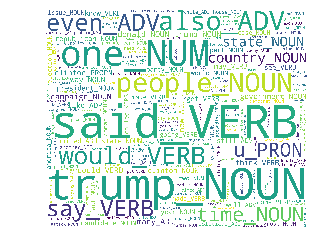

In [31]:
wordcloud2 = WordCloud(
                           background_color='white',
                           width=12000,
                           height=10000
                          ).generate(" ".join(train['feature']))

plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

### Lets check what is the distribution of news that contain "Trump", "clinton" & "Obama"

In [32]:
trump = train['feature'].str.contains("trump").values
clinton = train['feature'].str.contains("clinton").values
obama= train['feature'].str.contains("obama").values

presidents = [obama,clinton,trump]

trump = go.Histogram(
    x=trump,
    opacity=0.75,
    name='trump'
)
clinton = go.Histogram(
    x=clinton,
    opacity=0.75,
    name='clinton'
)
obama = go.Histogram(
    x=obama,
    opacity=0.75,
    name='obama'
)

presidents = [obama,clinton,trump]
layout = go.Layout(bargap=0.2,
    bargroupgap=0.1, title='News containing the political candidates name')
fig = go.Figure(data=presidents, layout=layout)

train.iplot(data = presidents, layout = layout)

### Let's check the distribution of the news length per target label

In [33]:
train['feature_len'] = train['feature'].astype(str).apply(len)
x0 = train["feature_len"].loc[train["target"]=="FAKE"]
x1 = train["feature_len"].loc[train["target"]=="REAL"]

Fake = go.Histogram(
    x=x0,
    opacity=0.75,
    name='fake',
    marker=dict(
        color='#FF0000'
    )
    
)
Real = go.Histogram(
    x=x1,
    opacity=0.75,
    name='real',
    marker=dict(
        color='#008000'
    )
)

data = [Fake, Real]
layout = go.Layout(barmode='overlay', title = "Word Length within targets")
fig = go.Figure(data=data, layout=layout)

train.iplot(data = data, layout = layout)

### Let's check the distribution of the news word count per target label

In [34]:
train['word_count'] = train['feature'].apply(lambda x: len(str(x).split()))

x0 = train["word_count"].loc[train["target"]=="FAKE"]
x1 = train["word_count"].loc[train["target"]=="REAL"]

Fake = go.Histogram(
    x=x0,
    opacity=0.75,
    name = 'fake',
    marker=dict(
        color='#FF0000')
)
Real = go.Histogram(
    x=x1,
    opacity=0.75,
    name='real',
    marker=dict(
        color='#008000'
    )
)

data = [Fake, Real]
layout = go.Layout(barmode='overlay', title = "Word Count within targets")
fig = go.Figure(data=data, layout=layout)

train.iplot(data = data, layout = layout)

## 6. Model creation and evaluation

### 6.1 Train Test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    train["feature"], train["target"], test_size=0.25, random_state=42
)

### Checking Bigrams

In [36]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(train['feature'], 20)
df3 = pd.DataFrame(common_words, columns = ['feature' , 'count'])
df3.groupby('feature').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

### 6.2 Naive Bayes + CountVectorizer

In [41]:
# building classifier using naive bayes
nb_cvec_pipeline = Pipeline([("cvec", CountVectorizer()), ("nb", MultinomialNB())])

# Tune GridSearchCV
pipe_params_nb_cvec = {
#     "cvec__max_df": [0.5, 0.7, 1],
#     "cvec__ngram_range": [(1, 1), (1, 2), (1, 3)],
#     "nb__alpha": [0.1, 0.05, 0.001]
    
    # Just for quick run
    "cvec__max_df": [0.5],
    "cvec__ngram_range": [(1, 3)],
    "nb__alpha": [0.05]
}

model_nb_cvec_gs = GridSearchCV(nb_cvec_pipeline, param_grid=pipe_params_nb_cvec, cv=5)
model_nb_cvec_gs.fit(X_train, y_train)

print("Best Train score: ", model_nb_cvec_gs.best_score_)
print("Test score: ", model_nb_cvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_nb_cvec_gs.best_params_)

Best Train score:  0.9040775401069518
Test score:  0.9028056112224448
Best parameters:  {'cvec__max_df': 0.5, 'cvec__ngram_range': (1, 3), 'nb__alpha': 0.05}


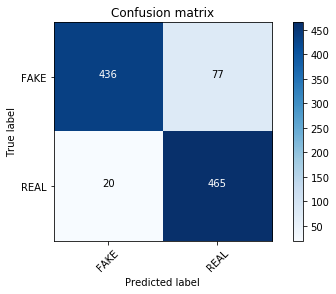

In [42]:
y_pred = model_nb_cvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.3 Naive Bayes + TFIDF

In [43]:
# building classifier using naive bayes
nb_tvec_pipeline = Pipeline([("tvect", TfidfVectorizer()), ("nb", MultinomialNB())])

# Tune GridSearchCV
pipe_params_nb_tvec = {
    # best: 'nb__alpha': 0.002, 'tvect__max_df': 0.7, 'tvect__min_df': 3, 'tvect__ngram_range': (1, 3)
    # Just to run quickly
    "tvect__max_df": [0.7],
    "tvect__min_df": [3],
    "tvect__ngram_range": [(1, 3)],
    "nb__alpha": [0.002],
}

model_nb_tvec_gs = GridSearchCV(
    nb_tvec_pipeline, param_grid=pipe_params_nb_tvec, cv=5, verbose=True
)
model_nb_tvec_gs.fit(X_train, y_train)

print("Best score: ", model_nb_tvec_gs.best_score_)
print("Test score: ", model_nb_tvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_nb_tvec_gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


Best score:  0.9151069518716578
Test score:  0.9168336673346693
Best parameters:  {'nb__alpha': 0.002, 'tvect__max_df': 0.7, 'tvect__min_df': 3, 'tvect__ngram_range': (1, 3)}


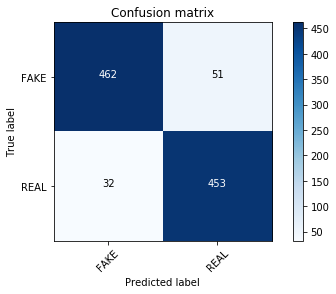

In [44]:
y_pred = model_nb_tvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.4 MaxEnt + CountVectorizer

In [45]:
# building classifier using naive bayes
me_cvec_pipeline = Pipeline([("cvec", CountVectorizer()), ('lr', LogisticRegression())])

# Tune GridSearchCV
pipe_params_me_cvec = {
    #'cvec__ngram_range': [(1,1), (2,2), (1,3)],
    #'lr__C': [0.01, 0.1, 1],
    
    # For quick run
    'cvec__ngram_range': [(1,3)],
    'lr__C': [0.1],
}

model_me_cvec_gs = GridSearchCV(me_cvec_pipeline, param_grid=pipe_params_me_cvec, cv=5)
model_me_cvec_gs.fit(X_train, y_train)

print("Best score: ", model_me_cvec_gs.best_score_)
print("Test score: ", model_me_cvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_me_cvec_gs.best_params_)

Best score:  0.9064171122994652
Test score:  0.9018036072144289
Best parameters:  {'cvec__ngram_range': (1, 3), 'lr__C': 0.1}


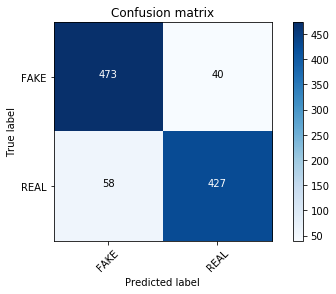

In [46]:
y_pred = model_me_cvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.5 MaxEnt + TfidfVectorizer

In [47]:
# building classifier using naive bayes
me_tvec_pipeline = Pipeline(
    [("tvect", TfidfVectorizer()), ("lr", LogisticRegression())]
)

# Tune GridSearchCV
pipe_params_me_tvec = {
    #     'lr__C': [0.01, 1],
    #     "tvect__max_df": [0.75, 0.98, 1.0],
    #     "tvect__min_df": [2, 3, 5],
    #     "tvect__ngram_range": [(1, 1), (1, 2), (1, 3)]
    
    # For quick run
    "lr__C": [1],
    "tvect__max_df": [0.75],
    "tvect__min_df": [3],
    "tvect__ngram_range": [(1, 3)],
}

model_me_tvec_gs = GridSearchCV(me_tvec_pipeline, param_grid=pipe_params_me_tvec, cv=5)
model_me_tvec_gs.fit(X_train, y_train)

print("Best score: ", model_me_tvec_gs.best_score_)
print("Test score: ", model_me_tvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_me_tvec_gs.best_params_)

Best score:  0.9007352941176471
Test score:  0.9078156312625251
Best parameters:  {'lr__C': 1, 'tvect__max_df': 0.75, 'tvect__min_df': 3, 'tvect__ngram_range': (1, 3)}


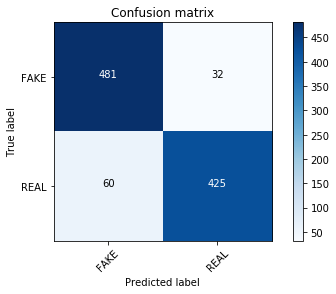

In [48]:
y_pred = model_me_tvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.6 SVM + CountVectorizer

In [49]:
svm_cvec_pipeline = Pipeline([("cvec", CountVectorizer()), ("svm", SGDClassifier())])

pipe_params_svm_cvec = {
    "cvec__max_df": [0.85],
    "cvec__ngram_range": [(1, 3)],
    'svm__penalty': ['l2'],
    "svm__alpha": [1e-05],
}

model_svm_cvec_gs = GridSearchCV(svm_cvec_pipeline, param_grid=pipe_params_svm_cvec, cv=5)
model_svm_cvec_gs.fit(X_train, y_train)

print("Best score: ", model_svm_cvec_gs.best_score_)
print("Test score: ", model_svm_cvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_svm_cvec_gs.best_params_)

Best score:  0.8907085561497327
Test score:  0.8847695390781564
Best parameters:  {'cvec__max_df': 0.85, 'cvec__ngram_range': (1, 3), 'svm__alpha': 1e-05, 'svm__penalty': 'l2'}


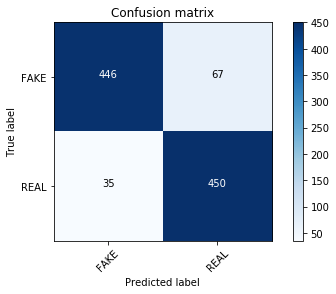

In [69]:
y_pred = model_svm_cvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.7 SVM + TfidfVectorizer

In [50]:
svm_tvec_pipeline = Pipeline([("tvec", TfidfVectorizer()), ("svm", SGDClassifier())])

pipe_params_svm_tvec = {
    "tvec__max_df": [0.85],
    "tvec__ngram_range": [(1, 3)],
    'svm__penalty': ['l2'],
    "svm__alpha": [1e-05],
}

model_svm_tvec_gs = GridSearchCV(svm_tvec_pipeline, param_grid=pipe_params_svm_tvec, cv=5)
model_svm_tvec_gs.fit(X_train, y_train)

print("Best score: ", model_svm_tvec_gs.best_score_)
print("Test score: ", model_svm_tvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_svm_tvec_gs.best_params_)

Best score:  0.9167780748663101
Test score:  0.9128256513026052
Best parameters:  {'svm__alpha': 1e-05, 'svm__penalty': 'l2', 'tvec__max_df': 0.85, 'tvec__ngram_range': (1, 3)}


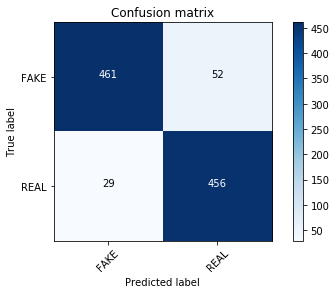

In [71]:
y_pred = model_svm_tvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.8 PAC + CountVectorizer

In [51]:
# Create a pipeline with TfidfVectorizer and model
pac_cvec_pipeline = Pipeline(
    [("cvec", CountVectorizer()), ("pac", PassiveAggressiveClassifier())]
)

# Tune GridSearchCV
pipe_params_pac_cvec = {
    "cvec__max_df": [0.75],
    "cvec__min_df": [3],
    "pac__C": [0, 1],
    "pac__loss": ["hinge"],
}

model_pac_cvec_gs = GridSearchCV(pac_cvec_pipeline, param_grid=pipe_params_pac_cvec, cv=5)
model_pac_cvec_gs.fit(X_train, y_train)

print("Best score:", model_pac_cvec_gs.best_score_)
print("Test score", model_pac_cvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_pac_cvec_gs.best_params_)

Best score: 0.8736631016042781
Test score 0.8857715430861723
Best parameters:  {'cvec__max_df': 0.75, 'cvec__min_df': 3, 'pac__C': 1, 'pac__loss': 'hinge'}


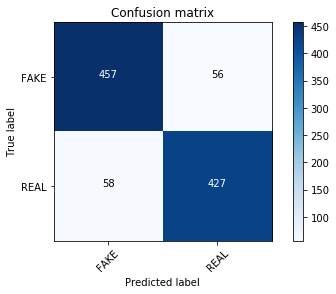

In [52]:
y_pred = model_pac_cvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 6.9 PAC + Tfidf

In [53]:
# Create a pipeline with TfidfVectorizer and model
pac_tvec_pipeline = Pipeline(
    [("tvec", TfidfVectorizer()), ("pac", PassiveAggressiveClassifier())]
)

# Tune GridSearchCV
pipe_params_pac_tvec = {'tvec__max_df': [0.7, 0.85],
               'tvec__ngram_range': [(1,1),(1,3)],
               'pac__C': [0, 1],
               'pac__loss': ['hinge', 'squared_hinge']}

model_pac_tvec_gs = GridSearchCV(pac_tvec_pipeline, param_grid=pipe_params_pac_tvec, cv=5)
model_pac_tvec_gs.fit(X_train, y_train)

print("Best score:", model_pac_tvec_gs.best_score_)
print("Test score", model_pac_tvec_gs.best_estimator_.score(X_test, y_test))
print("Best parameters: ", model_pac_tvec_gs.best_params_)

Best score: 0.9227941176470589
Test score 0.9268537074148296
Best parameters:  {'pac__C': 1, 'pac__loss': 'hinge', 'tvec__max_df': 0.85, 'tvec__ngram_range': (1, 1)}


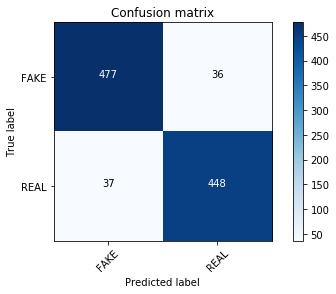

In [54]:
y_pred = model_pac_tvec_gs.best_estimator_.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## 7. Saving Predictions

In [56]:
best_model = model_pac_tvec_gs.best_estimator_

final_test_pred = best_model.predict(test["feature"])
test["label"] = final_test_pred

test[["ID", "title", "text", "label"]].to_csv("fake_or_real_news_test_predicted.csv", index = False)